In [1]:
%matplotlib inline

http://alleninstitute.github.io/AllenSDK/_static/examples/nb/mouse_connectivity.html

In [2]:
import pandas as pd
import numpy as np
import nibabel as nb
from nighres.io import io_mesh
import matplotlib.pyplot as plt
import seaborn as sns
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import pickle
from nipype.interfaces import fsl

### Download first level substructures of isocortex

In [3]:
mcc = MouseConnectivityCache(manifest_file=
                             '/home/julia/data/gradients/atlas/allen_api/mouse_connectivity_manifest.json')

In [4]:
structure_tree = mcc.get_structure_tree()

In [5]:
iso_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']
regions = structure_tree.children([iso_id])[0]

In [6]:
hdr = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz').header
aff = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz').affine
shape = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz').shape

In [43]:
for region in regions:
    mask, _ = mcc.get_structure_mask(region['id'], 
                                  '/home/julia/data/gradients/atlas/allen_api/regions/%s.nrrd' 
                                  % region['acronym'])
    nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/%s.nii.gz'
                                              % region['acronym'])

### Plot masks

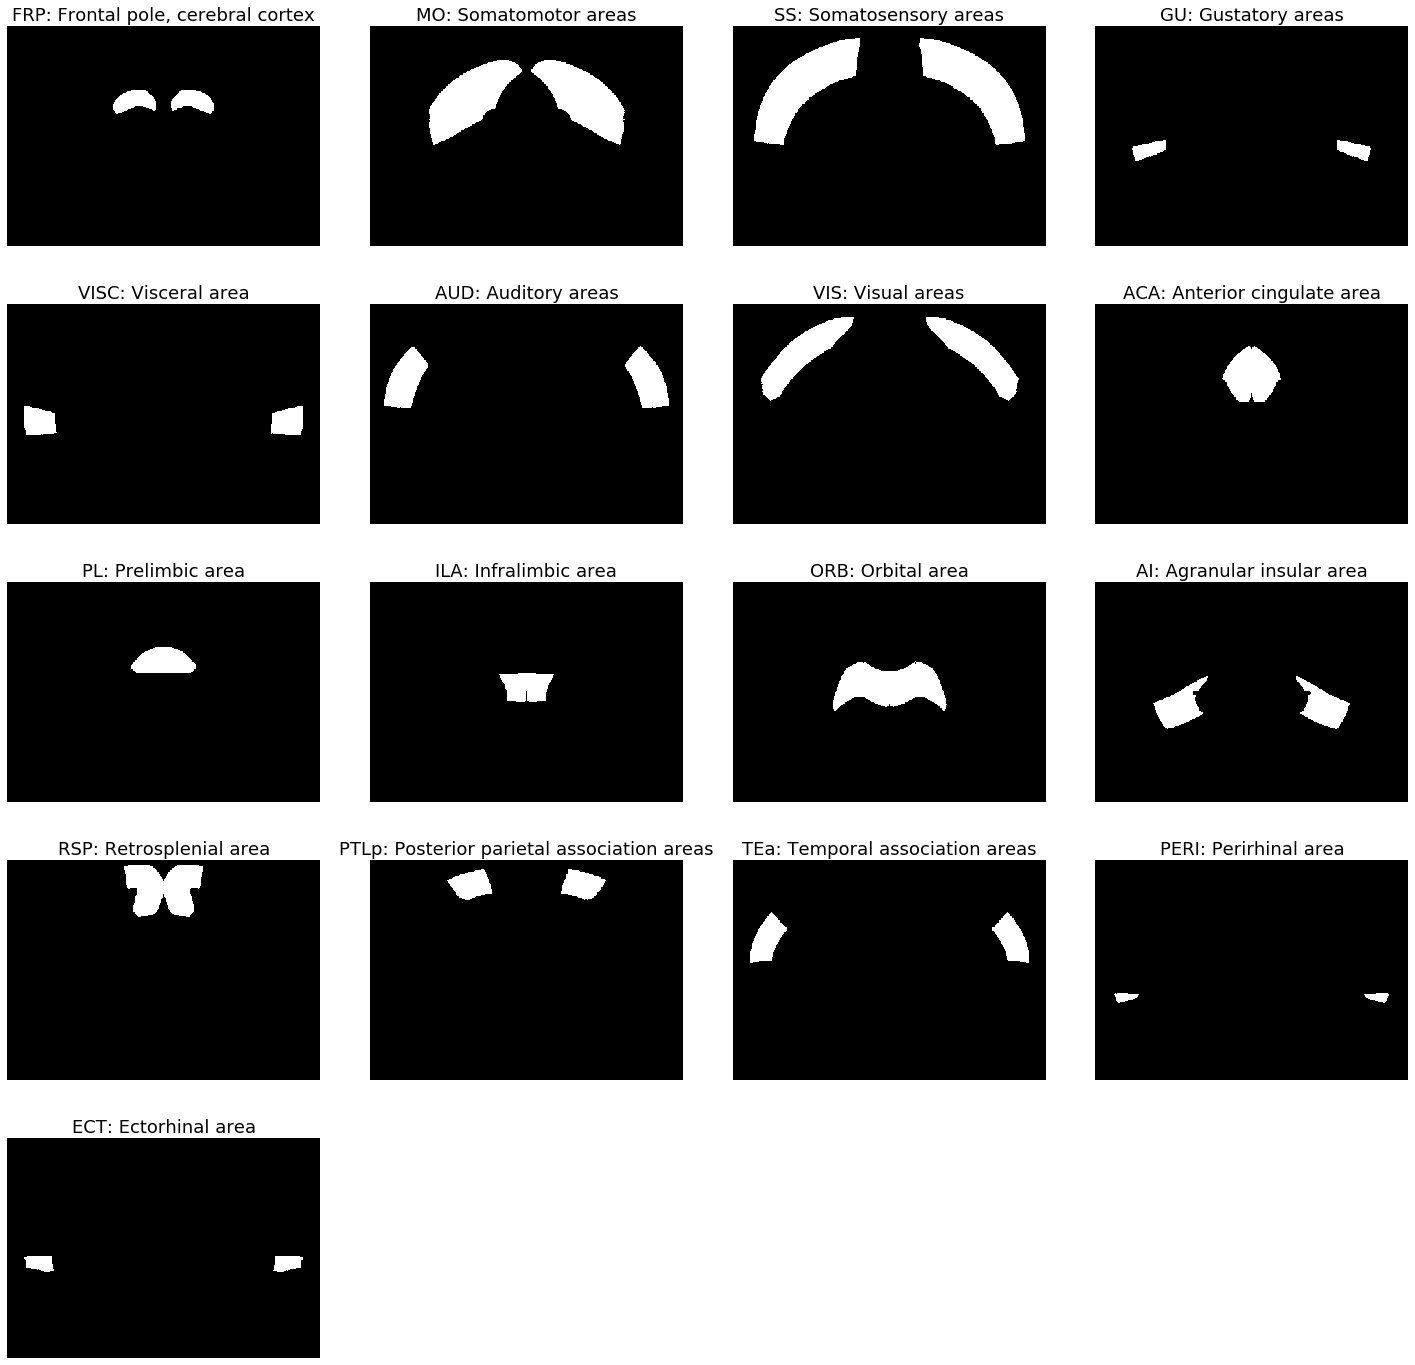

In [91]:
sns.set_context('talk')
fig = plt.figure(figsize=(20,20))
for n in range(len(regions)):
    mask = nb.load('/home/julia/data/gradients/atlas/allen_api/regions/%s.nii.gz' % regions[n]['acronym']).get_data()
    x = np.argmax(np.bincount(np.where(mask==1)[0]))
    fig.add_subplot(5,4,n+1)
    plt.imshow(mask[x,:,:], cmap='Greys_r');
    plt.axis('off');
    plt.title('%s: %s' %(regions[n]['acronym'], regions[n]['name']))
    plt.tight_layout()

### Save coarse annotation volume

In [7]:
annot = np.zeros(shape)
annot_dict = {}
for n in range(len(regions)):
    mask, _ = mcc.get_structure_mask(regions[n]['id'], 
                                  '/home/julia/data/gradients/atlas/allen_api/regions/%s.nrrd' 
                                  % regions[n]['acronym'])
    annot[mask==1] = n+1
    annot_dict[regions[n]['acronym']]=n+1

In [8]:
annot_dict

{'FRP': 1,
 'MO': 2,
 'SS': 3,
 'GU': 4,
 'VISC': 5,
 'AUD': 6,
 'VIS': 7,
 'ACA': 8,
 'PL': 9,
 'ILA': 10,
 'ORB': 11,
 'AI': 12,
 'RSP': 13,
 'PTLp': 14,
 'TEa': 15,
 'PERI': 16,
 'ECT': 17}

In [16]:
nb.Nifti1Image(annot, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot.nii.gz')

In [19]:
with open('/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot.pkl', 'wb') as f:
    pickle.dump(annot_dict, f)

### Resample to 200 um

In [23]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot.nii.gz",
                   apply_isoxfm=0.2,
                   interp="nearestneighbour",
                   out_file="/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_200um.nii.gz")
resamp.run()

### QA region proportions vol vs mesh

In [3]:
vol = nb.load('/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_200um.nii.gz').get_data()

In [16]:
mesh = io_mesh.load_mesh('/home/julia/data/gradients/results/regions/regions_sampled_mesh.vtk')
mesh = np.squeeze(mesh['data'])

In [20]:
vol_total = vol[vol!=0].shape[0]
mesh_total = mesh[mesh!=0].shape[0]

In [43]:
volsum=0
for r in regions:
    print(r['name'])
    print('vol: %f' %(vol[vol==annot_dict[r['acronym']]].shape[0] / vol_total * 100))
    print('mesh: %f' %(mesh[mesh==annot_dict[r['acronym']]].shape[0] / mesh_total * 100))
    print()

Frontal pole, cerebral cortex
vol: 0.740068
mesh: 0.987592

Somatomotor areas
vol: 19.903921
mesh: 18.080527

Somatosensory areas
vol: 26.674890
mesh: 16.350131

Gustatory areas
vol: 1.499610
mesh: 1.173293

Visceral area
vol: 1.960530
mesh: 2.312822

Auditory areas
vol: 4.687094
mesh: 3.958808

Visual areas
vol: 10.893274
mesh: 17.540306

Anterior cingulate area
vol: 4.420930
mesh: 1.949861

Prelimbic area
vol: 2.064399
mesh: 2.684224

Infralimbic area
vol: 0.746559
mesh: 0.151937

Orbital area
vol: 4.726045
mesh: 4.921077

Agranular insular area
vol: 6.400935
mesh: 5.942433

Retrosplenial area
vol: 8.634121
mesh: 15.396303

Posterior parietal association areas
vol: 1.992989
mesh: 1.612223

Temporal association areas
vol: 2.622695
mesh: 3.376382

Perirhinal area
vol: 0.642690
mesh: 1.114206

Ectorhinal area
vol: 1.389250
mesh: 2.447877



Seems better to calculate in volume and only use mesh for visualization

### Finer regions

In [52]:
# Motor
structure_tree.children([regions[1]['id']])[0][-2:]
mask, _ = mcc.get_structure_mask(985,'/home/julia/data/gradients/atlas/allen_api/regions/MOp.nrrd')
nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/MOp.nii.gz')
mask, _ = mcc.get_structure_mask(993,'/home/julia/data/gradients/atlas/allen_api/regions/MOs.nrrd')
nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/MOs.nii.gz')

In [53]:
# Somatomotor
structure_tree.children([regions[2]['id']])[0][-2:]
mask, _ = mcc.get_structure_mask(322,'/home/julia/data/gradients/atlas/allen_api/regions/SSp.nrrd')
nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/SSp.nii.gz')
mask, _ = mcc.get_structure_mask(378,'/home/julia/data/gradients/atlas/allen_api/regions/SSs.nrrd')
nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/SSs.nii.gz')

In [41]:
# Auditory
structure_tree.children([regions[5]['id']])[0]
mask, _ = mcc.get_structure_mask(1002,'/home/julia/data/gradients/atlas/allen_api/regions/AUDp.nrrd')
nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/AUDp.nii.gz')
!fslmaths AUD.nii.gz -sub AUDp.nii.gz AUDrest.nii.gz

In [44]:
# Visual
structure_tree.children([regions[6]['id']])[0][-8:]
mask, _ = mcc.get_structure_mask(385,'/home/julia/data/gradients/atlas/allen_api/regions/VISp.nrrd')
nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/VISp.nii.gz')
!fslmaths VIS.nii.gz -sub VISp.nii.gz VISrest.nii.gz

In [11]:
annot_finer_dict = {}
annot_finer_dict['FRP'] = 1
annot_finer_dict['MOp'] = 2
annot_finer_dict['MOs'] = 3
annot_finer_dict['SSp'] = 4
annot_finer_dict['SSs'] = 5
annot_finer_dict['GU'] = 6
annot_finer_dict['VISC'] = 7
annot_finer_dict['AUDp'] = 8
annot_finer_dict['AUDrest'] = 9
annot_finer_dict['VISp'] = 10
annot_finer_dict['VISrest'] = 11
annot_finer_dict['ACA'] = 12
annot_finer_dict['PL'] = 13
annot_finer_dict['ILA'] = 14
annot_finer_dict['ORB'] = 15
annot_finer_dict['AI'] = 16
annot_finer_dict['RSP'] = 17
annot_finer_dict['PTLp'] = 18
annot_finer_dict['TEa'] = 19
annot_finer_dict['PERI'] = 20
annot_finer_dict['ECT'] = 21

In [59]:
with open('/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer.pkl', 'wb') as f:
    pickle.dump(annot_finer_dict, f)

In [51]:
annot_finer = np.zeros(shape)
regions = list(annot_finer_dict.keys())
for n in range(len(regions)):
    mask = nb.load('/home/julia/data/gradients/atlas/allen_api/regions/%s.nii.gz' % regions[n]).get_data()
    annot_finer[mask==1] = annot_finer_dict[regions[n]]

In [52]:
nb.Nifti1Image(np.round(annot_finer), aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer.nii.gz')

In [53]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer.nii.gz",
                   apply_isoxfm=0.2,
                   interp="nearestneighbour",
                   out_file="/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer_200um.nii.gz")
resamp.run()

In [57]:
rounded = np.round(nb.load("/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer_200um.nii.gz").get_data())
hdr_200 = nb.load("/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_200um.nii.gz").header
aff_200 = nb.load("/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_200um.nii.gz").affine

In [58]:
nb.Nifti1Image(rounded, aff_200, hdr_200).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/isocortex_annot_finer_200um.nii.gz')

### Even finer regions

In [11]:
for region in regions:
    children = structure_tree.children([region['id']])[0]
    for child in children:
        if "layer" in child['name'].lower():
            pass
        elif child['id'] == 738:
            pass
        else:
            mask, _ = mcc.get_structure_mask(child['id'],
                                             '/home/julia/data/gradients/atlas/allen_api/regions/%s.nrrd' 
                                              % child['acronym'])
            nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/%s.nii.gz'
                                               % child['acronym'])

2019-11-29 17:43:28,889 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_746.nrrd


191129-17:43:28,889 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:30,690 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_104.nrrd


191129-17:43:30,690 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:32,410 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_111.nrrd


191129-17:43:32,410 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:34,154 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_119.nrrd


191129-17:43:34,154 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:35,714 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_894.nrrd


191129-17:43:35,714 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:37,418 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_879.nrrd


191129-17:43:37,418 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:39,181 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_886.nrrd


191129-17:43:39,181 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:40,696 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_312782546.nrrd


191129-17:43:40,696 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 17:43:42,209 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_417.nrrd


191129-17:43:42,209 allensdk.api.api.retrieve_file_over_http INFO:


In [12]:
finest = []
for region in regions:
    children = structure_tree.children([region['id']])[0]
    for child in children:
        if "layer" in child['name'].lower():
            pass
        elif child['id'] == 738:
            pass
        else:
            finest.append(child['acronym'])

In [13]:
# add the regions that have no subregions
for region in regions:
    if True in [(region['acronym'] in f) for f in finest]:
        pass
    else:
        finest.append(region['acronym'])

In [17]:
# add subregions of SSp
for ss in structure_tree.children([322])[0]:
    if "layer" in ss['name'].lower():
        pass
    else:
        #finest.append(ss['acronym'])
        mask, _ = mcc.get_structure_mask(ss['id'],
                                        '/home/julia/data/gradients/atlas/allen_api/regions/%s.nrrd' 
                                            % ss['acronym'])
        nb.Nifti1Image(mask, aff, hdr).to_filename('/home/julia/data/gradients/atlas/allen_api/regions/%s.nii.gz'
                                            % ss['acronym'])
#finest.remove('SSp')

2019-11-29 18:08:17,214 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_353.nrrd


191129-18:08:17,214 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 18:08:19,537 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_329.nrrd


191129-18:08:19,537 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 18:08:21,351 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_337.nrrd


191129-18:08:21,351 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 18:08:23,063 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_345.nrrd


191129-18:08:23,63 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 18:08:24,792 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_369.nrrd


191129-18:08:24,792 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 18:08:26,315 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_361.nrrd


191129-18:08:26,315 allensdk.api.api.retrieve_file_over_http INFO:


2019-11-29 18:08:27,875 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_182305689.nrrd


191129-18:08:27,875 allensdk.api.api.retrieve_file_over_http INFO:


In [16]:
df = pd.DataFrame(data=zip(range(1,len(finest)+1),finest),
                 columns=['id', 'acronym'])
df.to_csv('/home/julia/data/gradients/results/regions/finest_regions.csv')